## Constrained, Parallel, Multi-Objective BO in BoTorch with qNEHVI, and qParEGO

In this tutorial, we illustrate how to implement a constrained multi-objective (MO) Bayesian Optimization (BO) closed loop in BoTorch.

In general, we recommend using [Ax](https://ax.dev) for a simple BO setup like this one, since this will simplify your setup (including the amount of code you need to write) considerably. See [here](https://ax.dev/tutorials/multiobjective_optimization.html) for an Ax tutorial on MOBO. If desired, you can use a custom BoTorch model in Ax, following the [Using BoTorch with Ax](./custom_botorch_model_in_ax) tutorial. Given a `MultiObjective`, Ax will default to the $q$NEHVI acquisiton function. If desired, this can also be customized by adding `"botorch_acqf_class": <desired_botorch_acquisition_function_class>,` to the `model_kwargs`.

We use the parallel ParEGO ($q$ParEGO) [1] and parallel Noisy Expected Hypervolume Improvement ($q$NEHVI) [2]  acquisition functions to optimize a synthetic C2-DTLZ2 test function with $M=2$ objectives, $V=1$ constraint, and $d=4$ parameters. The two objectives are
$$f_1(\mathbf x) = (1+ g(\mathbf x_M))\cos\big(\frac{\pi}{2}x_1\big)$$
$$f_2(\mathbf x) = (1+ g(\mathbf x_M))\sin\big(\frac{\pi}{2}x_1\big)$$
where $g(\mathbf x) = \sum_{x_i \in \mathbf x_M} (x_i - 0.5)^2, \mathbf x \in [0,1]^d,$ and $\mathbf x_M$ represents the last $d - M +1$ elements of $\mathbf x$. Additionally, the C2-DTLZ2 problem uses the following constraint:

$$c(\mathbf x) = - \min \bigg[\min_{i=1}^M\bigg((f_i(\mathbf x) -1 )^2 + \sum_{j=1, j=i}^M (f_j^2 - r^2) \bigg), \bigg(\sum_{i=1}^M \big((f_i(\mathbf x) - \frac{1}{\sqrt{M}})^2 - r^2\big)\bigg)\bigg]\geq 0$$

where $\mathbf x \in [0,1]^d$ and $r=0.2$. 

The goal here is to *minimize* both objectives. Since BoTorch assumes maximization, we maximize the negative of each objective. Since there typically is no single best solution in multi-objective optimization problems, we seek to find the pareto frontier, the set of optimal trade-offs where improving one metric means deteriorating another.

[1] [S. Daulton, M. Balandat, and E. Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2006.05078)

[2] [S. Daulton, M. Balandat, and E. Bakshy. Parallel Bayesian Optimization of Multiple Noisy Objectives with Expected Hypervolume Improvement. Advances in Neural Information Processing Systems 34, 2021.](https://arxiv.org/abs/2105.08195)

**For batch optimization (or in noisy settings), we strongly recommend using $q$NEHVI rather than $q$EHVI [1] because it is far more efficient than $q$EHVI and mathematically equivalent in the noiseless setting.**

### Set dtype and device
Note: $q$EHVI aggressively exploits parallel hardware and is much faster when run on a GPU. See [1] for details.

In [217]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda:3" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Problem setup


In [218]:
target = torch.load('caco_target.pt')
domain = torch.load('caco_domain.pt')

import random
def problem(X: torch.Tensor, tensor: torch.Tensor) -> int:
    # Compare the 1*d tensor (row) with each row in the n*d tensor
    matches = (tensor == X).all(dim=1)
    
    # Find the index of the matching row
    match_idx = torch.where(matches)[0][-1]
    # If a match is found, return the index
    
    return match_idx.item()

    # Stack the list of rows into a tensor and return it
    output = torch.stack(output_rows)
    return output

d = 2000
M = 3
bounds = torch.zeros(2, domain.shape[1])
bounds[0,:] = torch.min(domain, dim = 0)[0]
bounds[1,:] = torch.max(domain, dim = 0)[0]

In [219]:
#need a evaluate_slack function
def evaluate_slack(Y, ref = torch.tensor([0.5, 80, -5]).to(**tkwargs)):
    vio_raw = Y -ref
    return (vio_raw).sum(dim = -1, keepdim = True)


def generate_initial_data(n):
    # generate training data
    ind = random.sample(range(target.shape[0]), n)
    train_x = domain[ind,:]
    train_obj = target[ind,:]
    # negative values imply feasibility in botorch
    train_con = -evaluate_slack(train_obj)
    return train_x, train_obj, train_con

#### Model initialization

We use a multi-output `SingleTaskGP` to model the two objectives with a homoskedastic Gaussian likelihood with an inferred noise level.

The models are initialized with $2(d+1)=10$ points drawn randomly from $[0,1]^{4}$.

In [220]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from gpytorch.kernels import ScaleKernel
base = TanimotoKernel()
covar_module = ScaleKernel(
base_kernel=base,
)


def initialize_model(train_x, train_obj, train_con):
    # define models for objective and constraint
    train_y = torch.cat([train_obj, train_con], dim=-1)
    models = []
    for i in range(train_y.shape[-1]):
        models.append(
            SingleTaskGP(
                train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1), covar_module = covar_module,train_Yvar= torch.zeros((train_x.shape[0],1)) + 0.005**2
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step for $q$NEHVI
The helper function below initializes the $q$NEHVI acquisition function, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

For this example, we'll use a small batch of $q=2$. Passing the keyword argument `sequential=True` to the function `optimize_acqf`specifies that candidates should be optimized in a sequential greedy fashion (see [1] for details why this is important). A simple initialization heuristic is used to select the 10 restart initial locations from a set of 512 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

**Reference Point**

$q$NEHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

**Integrating over function values at in-sample designs**

$q$NEHVI integrates over the unknown function values at the previously evaluated designs (see [2] for details). Therefore, we need to provide the previously evaluated designs (`train_x`, *normalized* to be within $[0,1]^d$) to the acquisition function.

**Pruning baseline designs**
To speed up integration over the function values at the previously evaluated designs, we prune the set of previously evaluated designs (by setting `prune_baseline=True`) to only include those which have positive probability of being on the current in-sample Pareto frontier.

In [221]:
from botorch.acquisition.multi_objective.monte_carlo import (
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 1
NUM_RESTARTS = 4
RAW_SAMPLES = 4

standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1

c = 0
def optimize_qnehvi_and_get_observation(model, train_x, train_obj, train_con, sampler):
    """Optimizes the qNEHVI acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, problem.bounds)
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point
        X_baseline=train_x,
        sampler=sampler,
        prune_baseline=False,
        # define an objective that specifies which outcomes are the objectives
        objective=IdentityMCMultiOutputObjective(outcomes=[0, 1]),
        # specify that the constraint is on the last outcome
        constraints=[lambda Z: Z[..., -1]],
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = target[problem(new_x, domain),:]
    # negative values imply feasibility in botorch
    new_con = -evaluate_slack(new_x)
    return new_x, new_obj, new_con

#### Define a helper function that performs the essential BO step for $q$ParEGO
The helper function below similarly initializes $q$ParEGO, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

$q$ParEGO uses random augmented chebyshev scalarization with the `qExpectedImprovement` acquisition function. In the parallel setting ($q>1$), each candidate is optimized in sequential greedy fashion using a different random scalarization (see [1] for details).

To do this, we create a list of `qExpectedImprovement` acquisition functions, each with different random scalarization weights. The `optimize_acqf_list` method sequentially generates one candidate per acquisition function and conditions the next candidate (and acquisition function) on the previously selected pending candidates.

In [222]:
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.objective import GenericMCObjective


def optimize_qparego_and_get_observation(model, train_obj, train_con, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    # sample random weights
    weights = sample_simplex(3, **tkwargs).squeeze()
    # construct augmented Chebyshev scalarization
    scalarization = get_chebyshev_scalarization(weights=weights, Y=train_obj)
    # initialize the scalarized objective (w/o constraints)
    scalarized_objective = GenericMCObjective(
        # the last element of the model outputs is the constraint
        lambda Z, X: scalarization(Z[..., :-1]),
    )
    train_y = torch.cat([train_obj, train_con], dim=-1)
    acq_func = qExpectedImprovement(  # pyre-ignore: [28]
        model=model,
        objective=scalarized_objective,
        best_f=scalarized_objective(train_y).max(),
        constraints=[lambda Z: Z[..., -1]],
        sampler=sampler,
    )
    # optimize
    candidates, acq_v = optimize_acqf_discrete(
        acq_function = acq_func,
        choices  = domain,
        q = 1)
    # observe new values
    new_x = candidates
    new_obj = target[problem(new_x, domain),:].unsqueeze(0)
    # negative values imply feasibility in botorch
    new_con = -evaluate_slack(new_obj)
    return new_x, new_obj, new_con, acq_v

### Perform Bayesian Optimization loop with $q$EHVI and $q$ParEGO
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run one trial with `N_BATCH=20` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=128` samples.

*Note*: Running this may take a little while.

In [223]:
import time
import warnings
from metrics import HV
from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.pareto import is_non_dominated
warnings.filterwarnings('ignore')
print('O'*50)
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
c = 0
random_seeds = [83810, 14592, 3278, 97196, 36048, 32098, 29256, 18289, 96530, 13434, 88696, 97080, 71482, 11395, 77397, 55302, 4165, 3905, 12280, 28657, 30495, 66237, 78907, 3478, 73563,
26062, 93850, 85181, 91924, 71426, 54987, 28893, 58878, 77236, 36463, 851, 99458, 20926, 91506, 55392, 44597, 36421, 20379, 28221, 44118, 13396, 12156, 49797, 12676, 47052]
N_BATCH =60
MC_SAMPLES = 128 if not SMOKE_TEST else 16
verbose = True
for seed  in random_seeds[:10]:
    target = torch.load('caco_target.pt')
    domain = torch.load('caco_domain.pt')

    torch.manual_seed(seed)
    hvs_qparego, hvs_random = [], []

    # call helper functions to generate initial training data and initialize model
    train_x_qparego, train_obj_qparego, train_con_qparego = generate_initial_data(
        n= 64
    )
    mll_qparego, model_qparego = initialize_model(
        train_x_qparego, train_obj_qparego, train_con_qparego
    )

    '''train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi = (
        train_x_qparego,
        train_obj_qparego,
        train_con_qparego,
    )'''
    train_x_random, train_obj_random, train_con_random = (
        train_x_qparego,
        train_obj_qparego,
        train_con_qparego,
    )

    '''mll_qnehvi, model_qnehvi = initialize_model(
        train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi
    )
    '''
    # compute pareto front
    volume = HV(train_obj_qparego, torch.tensor([0.5, 80, -5]).to(**tkwargs))

    hvs_qparego.append(volume)
    #hvs_qnehvi.append(volume)
    hvs_random.append(volume)
    Acq = []
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_qparego)
        #fit_gpytorch_mll(mll_qnehvi)

        # define the qParEGO and qNEHVI acquisition modules using a QMC sampler
        qparego_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    # qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        # optimize acquisition functions and get new observations
        (
            new_x_qparego,
            new_obj_qparego,
            new_con_qparego,
            new_acq_v_qparego
        ) = optimize_qparego_and_get_observation(
            model_qparego, train_obj_qparego, train_con_qparego, qparego_sampler
        )
        '''new_x_qnehvi, new_obj_qnehvi, new_con_qnehvi = optimize_qnehvi_and_get_observation(
            model_qnehvi, train_x_qnehvi, train_obj_qnehvi, train_con_qnehvi, qnehvi_sampler
        )'''
        new_x_random, new_obj_random, new_con_random = generate_initial_data(n=BATCH_SIZE)

        # update training points
        train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
        train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
        train_con_qparego = torch.cat([train_con_qparego, new_con_qparego])

        '''train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
        train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
        train_con_qnehvi = torch.cat([train_con_qnehvi, new_con_qnehvi])
    '''
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])
        train_con_random = torch.cat([train_con_random, new_con_random])
        #append acqvs
        Acq.append(new_acq_v_qparego)
        # update progress
        for hvs_list, train_obj in zip(
            (hvs_random, hvs_qparego),
            (train_obj_random, train_obj_qparego)
        ):
            # compute pareto front
            volume = HV(train_obj, torch.tensor([0.5, 80, -5]).to(**tkwargs))
            hvs_list.append(volume)
        print(f'round{iteration}: ', 'qparego: ', hvs_qparego[-1], 'random: ',hvs_random[-1] )
        ###prune candidate###
        mask = torch.tensor([True]*target.shape[0])
        mask[problem(new_x_qparego, domain)] = False
        domain = domain[mask, :]
        target = target[mask, :]
        ####################

        # reinitialize the models so they are ready for fitting on next iteration
        # Note: we find improved performance from not warm starting the model hyperparameters
        # using the hyperparameters from the previous iteration
        mll_qparego, model_qparego = initialize_model(
            train_x_qparego, train_obj_qparego, train_con_qparego
        )
    c +=1
    torch.save(torch.tensor(hvs_qparego), f'hv_qparego_caco_{c}.pt')
    torch.save(torch.tensor(train_obj_qparego), f'obj_qparego_caco_{c}.pt')
    print('O', end='')
    

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO


round1:  qparego:  1.319601334921234 random:  1.319601334921234
round2:  qparego:  1.319601334921234 random:  1.319601334921234
round3:  qparego:  1.319601334921234 random:  1.319601334921234
round4:  qparego:  1.319601334921234 random:  1.319601334921234
round5:  qparego:  1.319601334921234 random:  1.319601334921234
round6:  qparego:  1.319601334921234 random:  1.319601334921234
round7:  qparego:  1.319601334921234 random:  1.319601334921234
round8:  qparego:  2.711263122605369 random:  1.319601334921234
round9:  qparego:  2.711263122605369 random:  1.319601334921234
round10:  qparego:  2.711263122605369 random:  1.319601334921234
round11:  qparego:  2.711263122605369 random:  1.319601334921234
round12:  qparego:  2.711263122605369 random:  1.319601334921234
round13:  qparego:  2.711263122605369 random:  1.319601334921234
round14:  qparego:  2.711263122605369 random:  1.319601334921234
round15:  qparego:  2.711263122605369 random:  1.319601334921234
round16:  qparego:  2.711263122605

In [224]:
new_obj_qparego

tensor([[  0.3175, 169.7800,  -5.2200]], dtype=torch.float64)

#### Plot the results
The plot below shows the log feasible hypervolume difference: the log difference between the hypervolume of the true feasible pareto front and the hypervolume of the observed (feasible) pareto front identified by each algorithm. The log feasible hypervolume difference is plotted at each step of the optimization for each of the algorithms.

The plot show that $q$NEHVI vastly outperforms the $q$ParEGO and Sobol baselines.

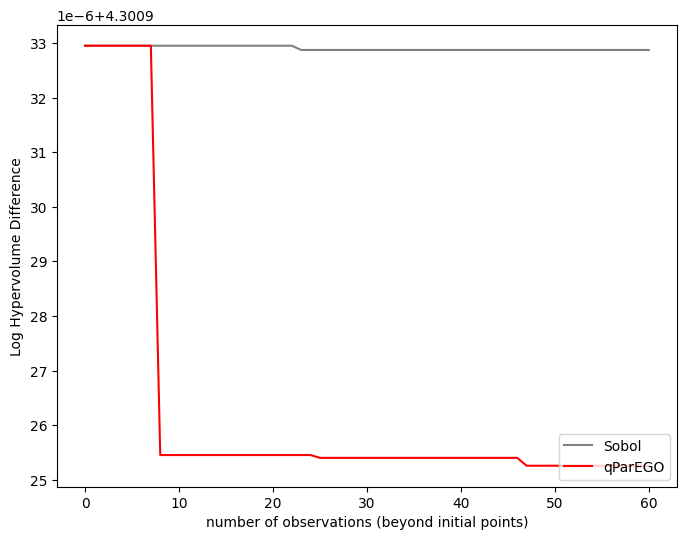

In [225]:
import numpy as np
from matplotlib import pyplot as plt


%matplotlib inline


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(20000 - np.asarray(hvs_qparego))
#log_hv_difference_qnehvi = np.log10(problem.max_hv - np.asarray(hvs_qnehvi))
log_hv_difference_rnd = np.log10(20000 - np.asarray(hvs_random))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(
    iters,
    log_hv_difference_rnd,
    label="Sobol",
    linewidth=1.5,
    color="gray",
)
ax.plot(
    iters,
    log_hv_difference_qparego,
    label="qParEGO",
    linewidth=1.5,
    color="red",
)
'''ax.plot(
    iters,
    log_hv_difference_qnehvi,
    label="qNEHVI",
    linewidth=1.5,
    color="blue",
)'''
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="Log Hypervolume Difference",
)
ax.legend(loc="lower right")

ValueError: x and y must have same first dimension, but have shapes (61,) and (60,)

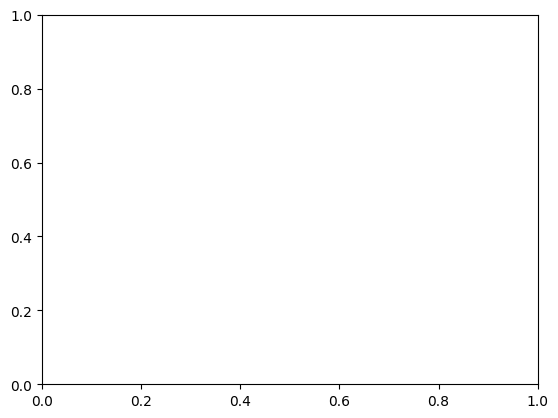

In [226]:
plt.plot(hvs_qparego, Acq)

In [ ]:
Acq

#### Plot the observations colored by iteration

To examine optimization process from another perspective, we plot the collected observations under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$NEHVI shows that the $q$NEHVI quickly identifies the pareto front and most of its evaluations are very close to the pareto front. $q$ParEGO also identifies has many observations close to the pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the pareto front compared to $q$NEHVI, which explicitly attempts focuses on improving the pareto front. Sobol generates random points and has few points close to the pareto front

In [ ]:
from matplotlib.cm import ScalarMappable
import matplotlib


fig, axes = plt.subplots(1, 2, figsize=(17, 5))
algos = ["Sobol", "qParEGO"]
cm = plt.get_cmap("viridis")

batch_number = torch.cat(
    [
        torch.zeros(2 * (d + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()

for i, train_obj in enumerate((train_obj_random, train_obj_qparego)):
    sc = axes[i].scatter(
        train_obj[:, 0].cpu().numpy(),
        train_obj[:, 1].cpu().numpy(),
        c=batch_number,
        alpha=0.8,
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
    '''axes[i].set_xlim(-2.5, 0)
    axes[i].set_ylim(-2.5, 0)'''
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

In [ ]:
from metrics import HV

In [ ]:
HV(train_obj_qparego, torch.tensor([8, -60, -350]).to(**tkwargs))